## Questão 1

## Questão 2: Perceptron Backpropagation 

## Problema

Implemente uma rede perceptron de múltiplas camadas treinando-a com os seguinte algoritmos
    
  __a)__ algoritmo da retropropagação em modo estocástico usando a regra delta
    
  __b)__ algoritmo da retropropagação em modo por lote usando a regra delta
   
  __c)__ algoritmo da retropropagação usando a regra delta com termo do momento
    
    
## Características do dados

//TODO

## Geração atomática de dados

//TODO

In [1]:
import statistics as st
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from misc import plots

## Funções de Ativação

Foram implementadas funções básicas de ativação para serem opções no uso na rede.

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

def degrau(x, derivative=False):
    if derivative:
        np.where(x>0.5,1,1)
    return np.where(x>0.5,1,0)

def step(x,derivative=False):
    if derivative:
        return np.where(x>0,1,1)
    return np.where(x>0,1,0)

## Função de Custo

In [3]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

## Plotagem dos erros

In [4]:
def plot_error(data, title=""):
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("errors")
    plt.plot(data)
    plt.show()

## Classe Layer

A classe Layer representa uma layer da rede guardando a entrada da camada, pesos, biases, função de ativação e saída da camada.

### Parâmetros

- __input_dim__: dimensão dos dados de entrada da camada
- ___units___: quantidade de neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede

### Atributos

- __input__: dados de entrada da camada
- __weights__: matriz todos os pesos de todos os neutônios da camada
- __biases__: vetor com os valores dos bias de todos os neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede
- __activ_out__: guarda os valores resultantes da função de ativação



In [5]:
class Layer:
    def __init__(self, input_dim, output_dim, activation=degrau, use_bias=True):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.biases = np.random.randn(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.input_dim = input_dim
        self.use_bias = use_bias
        self.dweights, self.dbias = None, None
        self._dweights, self._dbias, self._prev_dweights = None, None, 0.0

## Classe NeuralNetwork

A classe representa a Rede Neural, na caso o Perceptron.

### Atributos

- __layers__: conjunto de layers da rede


In [6]:
class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, momentum=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.momentum = momentum
        
    def fit(self, 
            x, 
            y, 
            x_valid=None,
            y_valid=None,
            batch_size=1,
            epochs=100,
            verbose=10,
            backpropagation=True,
            accuracy=True):
        '''
            Função de treinamento
            Parâmetros:
                x - entradas
                y - saídas esperadas
                learning_rate - taxa de aprendizagem
                epochs - quantidade de épocas de treinamento
                verbose - passos para verificação da época
        '''
        errors_train = []
        errors_valid = []
        batch_count = 0
        
        for epoch in range(epochs+1):
            error_epoch = []
            for i in range(batch_size, x.shape[0], batch_size):
                
                initial = 0 if i == 1 else i - batch_size
                #print(x[initial : i])
                y_pred = []
                
                x_b = x[initial : i]
                y_b = y[initial : i]

                for x_i, y_i in zip(x_b, y_b):
                    x_i =  x_i.reshape(1, x.shape[1])

                    y_pred_i = self.__feedforward(x_i)
                    y_pred.append(y_pred_i)

                    erro = y_i - y_pred_i
                    error_epoch.append(st.median(erro[0]))
                
                for x_i, y_i, y_pred_i in zip(x_b, y_b, y_pred):
                    if backpropagation:
                        self.__backpropagation(y_i, y_pred_i)
                    else:
                        for layer in self.layers:
                            layer.weights += self.learning_rate * np.dot(erro.T, x_i)
                            layer.biases += self.learning_rate * erro[0]
            
            # calculo do erro de predição
            if x_valid is not None and y_valid is not None:
                if accuracy:
                    y_pred = self.prediction(x_valid)
                    acc = accuracy_score(y_valid, y_pred)
                    errors_valid.append(1 - acc)
            errors_train.append(st.median(error_epoch))
            
            if epoch % verbose == 0:
                cost = self.cost_func(y_i, y_pred)
                print("epoch: {0:=4}/{1}\nerror: {2}".format(epoch, epochs, st.median(error_epoch)))
            
        return errors_train, errors_valid
    
    def add_layer(self, layer):
        '''
            Método para adição de layers ao modelo
            Parâmetros:
                layer - Layer a se adicionada ao modelo
        '''
        self.layers.append(layer)
    
    def __feedforward(self, x):
        '''
            Método de Feedforward - Efetua a multiplicação das entradas pelos pesos, soma ao bias, aplica função de ativação
            Parâmetros:
                x - dados de entrada
        '''
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def prediction(self, x):
        '''
            Método de Predição - Gera um conjunto de valores resultante do processo de FeedForward nos para os dados de entrada
            Parâmetros:
                x - dados de entrada
        '''
        y_pred = []
        
        for data in x:
            pred = self.__feedforward(data)

            for p in pred:
                pred = p
                break
    
            y_pred.append(pred)
            
        return np.array(y_pred)
    
    def evaluate(self,y_pred, y, dtype=int):
        '''
            Método Evaluate - Verifica a accuracy da rede
            Parâmetros:
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
                dtype - tipo dos dados
        '''
        score = 0

        for y_i, y_pred_i in zip(y,y_pred):
            if np.equal(np.argmax(y_i),np.argmax(y_pred_i[0])):
                score+=1
                
        return score/y.shape[0]

    def __backpropagation(self, y,y_pred):
            last_delta = self.cost_func(y, y_pred, derivative=True)
            for layer in reversed(self.layers):
                dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
                last_delta = np.dot(dactivation, layer.weights)
                layer._dweights = np.dot(dactivation.T, layer.input)
                layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)

            for layer in reversed(self.layers):
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases

## Execução

__1__ - A rede é inicializada

__2__ - Os dados de entrada e saida são obtidos

__3__ - Treinamento é feito com 80% dos dados e o Teste com os 20% restantes

__4__ - Accuracy da rede é verificada

## Arquitetura Usada

//TODO

## Parâmetros utilizados

//TODO

In [7]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q2/data_x_2.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q2/data_y_2.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

## 2 a) Treinamento Estocástico

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 100


epoch:    0/100
error: 0.0
epoch:   50/100
error: 0.0
epoch:  100/100
error: 0.0


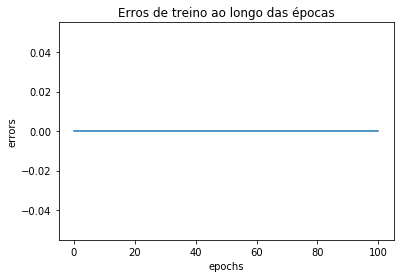

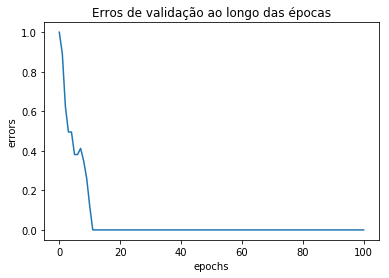

1.0


In [24]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=100, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

## 2 b) Treinamento com Batch

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Batch: 5
 - Épocas: 200

epoch:    0/200
error: 0.0
epoch:   50/200
error: 0.0
epoch:  100/200
error: 0.0
epoch:  150/200
error: 0.0
epoch:  200/200
error: 0.0


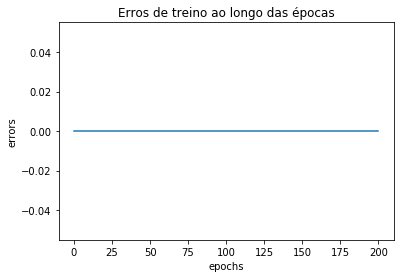

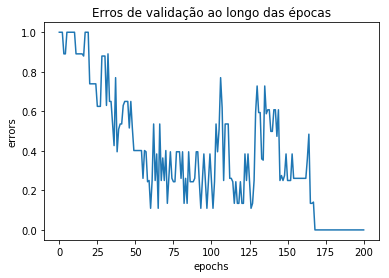

1.0


In [25]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=5, epochs=200, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

## 2 c)

// TODO

epoch:    0/100
error: 0.0
epoch:   50/100
error: 0.0
epoch:  100/100
error: 0.0


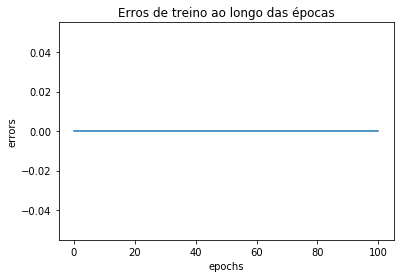

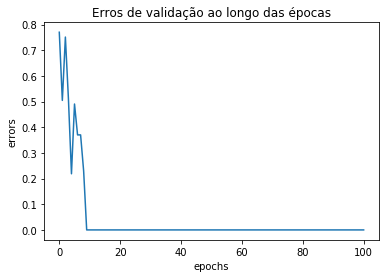

1.0


In [26]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=100, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

# Questão 3 - Convergência dos Algoritmos

## Problema

Usando algoritmos implementados na questão 2, aproxime as funções abaixo. Compare os resultados com as curvas exatas, para o caso dos itens b e c e apresente para cada caso a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação. Faça uma análise comparativa sobre a convergência de cada um dos algoritmos.

  __a)__ Função lógica XOR
  
  __b)__ f(x) = sen(pi*x) / pi*x
  
## 3 a)

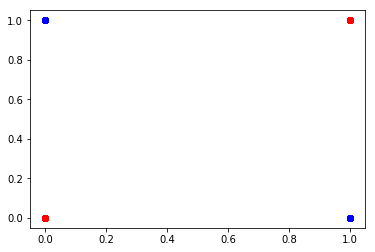

In [27]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q3/data_x_3a.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q3/data_y_3a.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

for index, y_i in enumerate(y):
    if y_i == 1:
        plt.plot(x[index][0], x[index][1], 'bo')
    else:
        plt.plot(x[index][0], x[index][1], 'ro')

plt.show()

### Estocástico

epoch:    0/300
error: 1.0
epoch:   50/300
error: 0.0
epoch:  100/300
error: 0.0
epoch:  150/300
error: 0.0
epoch:  200/300
error: 0.0
epoch:  250/300
error: 0.0
epoch:  300/300
error: 0.0


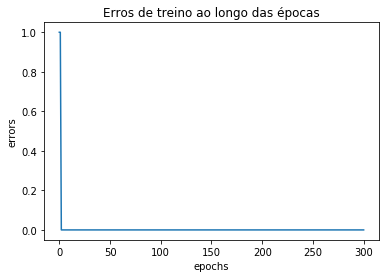

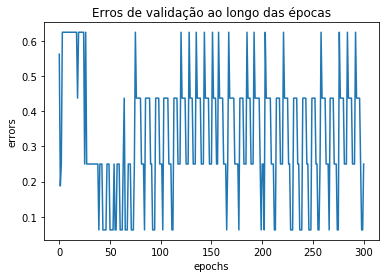

0.75


In [28]:
nn = NeuralNetwork(learning_rate=0.01)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, epochs=300, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

### Batch

epoch:    0/800
error: 0.0
epoch:  200/800
error: 0.0
epoch:  400/800
error: 0.0
epoch:  600/800
error: 0.0
epoch:  800/800
error: 0.0


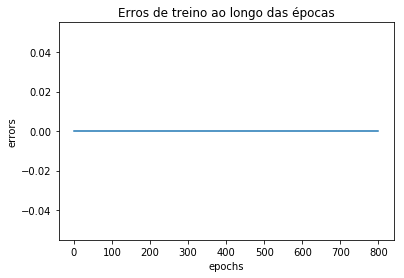

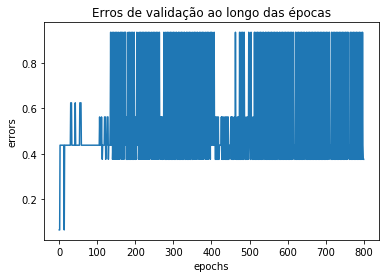

0.625


In [29]:
nn = NeuralNetwork(learning_rate=0.05)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=5 ,epochs=800, verbose=200)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

### Momento

// TODO

epoch:    0/300
error: 0.0
epoch:   50/300
error: 0.0
epoch:  100/300
error: 0.0
epoch:  150/300
error: 0.0
epoch:  200/300
error: 0.0
epoch:  250/300
error: 0.0
epoch:  300/300
error: 0.0


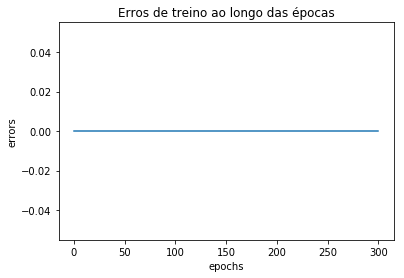

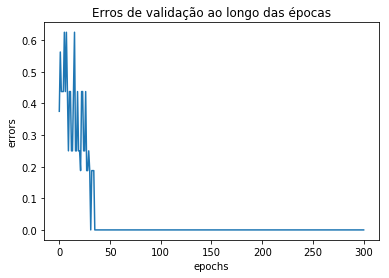

1.0


In [30]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.01, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, epochs=300, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

## 3 b)

// TODO

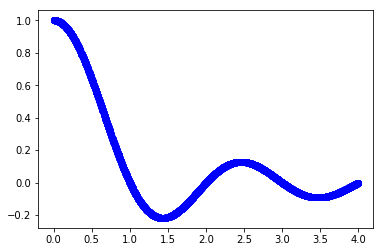

In [12]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q3/data_x_3b.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q3/data_y_3b.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

plt.plot(x, y, 'bo')
plt.show()

### Estocástico

epoch:    0/500
error: 0.011787394189661182
epoch:   50/500
error: 0.0010574526134761453
epoch:  100/500
error: 0.0006194309608833215
epoch:  150/500
error: 0.00011290950256817242
epoch:  200/500
error: 9.472124752385458e-06
epoch:  250/500
error: 0.00012960245980087048
epoch:  300/500
error: 0.0002652620679769735
epoch:  350/500
error: 0.0003971280274384925
epoch:  400/500
error: 0.00039166783685021245
epoch:  450/500
error: 0.0003301818161145498
epoch:  500/500
error: 0.00023653322143461775


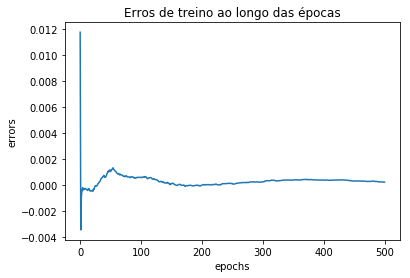

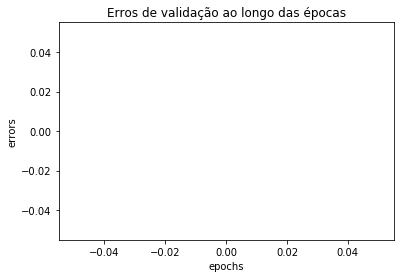

0.0


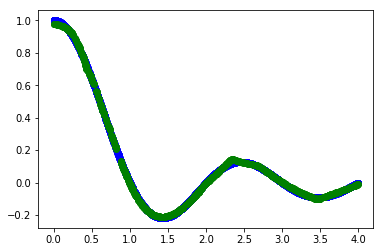

In [33]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=20, activation=relu))
nn.add_layer(Layer(input_dim=20, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=1, epochs=500, verbose=50, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)

check = 0
for valid, pred in zip(y_valid, y_pred): 
    #print(valid, pred)
    
    if valid[0] == pred[0]:
        check += 1
        
print(check / y_valid.shape[0])

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

## Batch

In [ ]:
nn = NeuralNetwork(learning_rate=0.01)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=4, activation=tanh))
nn.add_layer(Layer(input_dim=4, output_dim=4, activation=relu))
nn.add_layer(Layer(input_dim=4, output_dim=4, activation=relu))
nn.add_layer(Layer(input_dim=4, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=10, epochs=1000, verbose=100, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)

check = 0
for valid, pred in zip(y_valid, y_pred): 
    #print(valid, pred)
    
    if valid[0] == pred[0]:
        check += 1
        
print(check / y_valid.shape[0])

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

## Momento

epoch:    0/100
error: 0.0023598707375702584
epoch:   20/100
error: 0.001151493858109115
epoch:   40/100
error: 0.000544560069661304
epoch:   60/100
error: 0.00020510134157508686
epoch:   80/100
error: 0.0002517439606696259
epoch:  100/100
error: 0.0002845719892336819


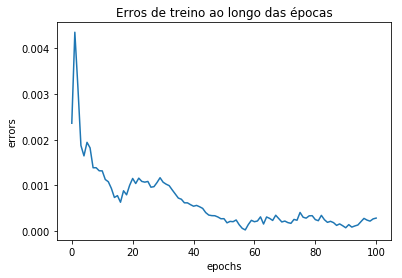

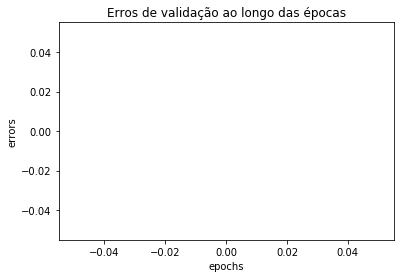

0.0


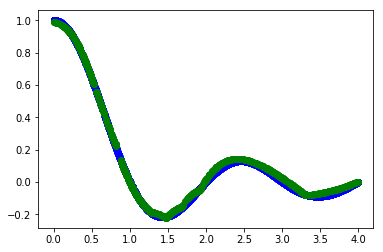

In [13]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=20, activation=relu))
nn.add_layer(Layer(input_dim=20, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=1, epochs=100, verbose=20, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)

check = 0
for valid, pred in zip(y_valid, y_pred): 
    #print(valid, pred)
    
    if valid[0] == pred[0]:
        check += 1
        
print(check / y_valid.shape[0])

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

# Questão 4 - Classificação do Circulo

## Problema

Considere um problema de classificação de padrões constituído de oito padrões. A distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no círculo um losango também centrado na origem e com lados iguais a raiz de 2. Os dados das classe C1, C2, C3, C4 corresponde aos quatro setores do losango e as outras quatro classes correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto de treinamento e um conjunto de validação. Treine uma rede perceptron para classificar os padrões associados a cada uma das classes. Verifique o desempenho do classificador usando o conjunto de validação e calculando a matriz de confusão.

## Leitura dos dados

In [117]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q4/data_x_4.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q4/data_y_4.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

# colors = {0:'black', 1:'red', 2:'blue', 3:'green', 4:'orange', 5:'purple', 6:'hotpink', 7:'yellow'}

# plt.figure(figsize=(5,5))
# plt.scatter(x[:,0], x[:,1], s = 3, c=[colors[yp] for yp in y])
# plt.axis('equal')
# plt.show()

## Modelo

In [119]:
nn = NeuralNetwork(learning_rate=0.01)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=linear))
nn.add_layer(Layer(input_dim=20, output_dim=y.shape[1], activation=linear))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=10, epochs=1000, verbose=100, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in add


epoch:    0/1000
error: nan


KeyboardInterrupt: 